<a href="https://colab.research.google.com/github/vitaliy-sharandin/data_science_projects/blob/master/portfolio/eda/Global_climate_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global and local pollution influence EDA
This project's purpose is to analyse global CO2 pollution level and its correlation with temperature's rise globally and in Krakow as well as to analyse most prominent local exhaust pollutants(NO2, CO) levels and how they behave throughout seasons in Krakow.

# Datasets

Global
* Temperature
  * https://climatedata.imf.org/datasets/4063314923d74187be9596f10d034914_0/explore
* Emmissions
  * https://ourworldindata.org/co2-and-greenhouse-gas-emissions
  * https://github.com/owid/co2-data

Krakow
* Temperature
  * https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/miesieczne/klimat/
* Emissions
  * https://powietrze.gios.gov.pl/pjp/archives
* Data parsing methods
  * https://github.com/vitaliy-sharandin/data_science_projects/blob/master/utils/krakow_pollution_data_parser.py

In [ ]:
!pip install -U -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 34.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import load_dataset, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

This project was quite challenging in terms of search for most up-to-date data and its cleaning. Here is a brief description of datasets and their discrepancies.
* Global temperature and pollution datasets are annual and up to 2022.
* Krakow data is originally monthly and updated up to September 2023.

In [ ]:
global_temp_anomaly_df = load_dataset("vitaliy-sharandin/climate-global-temp-anomaly")['train'].to_pandas().set_index('dt')
country_temp_df = load_dataset("vitaliy-sharandin/climate-global-temp-country")['train'].to_pandas().set_index('dt')
krakow_temp_df = load_dataset("vitaliy-sharandin/climate-krakow-temp-monthly")['train'].to_pandas().set_index('dt')

pollution_region_df = load_dataset("vitaliy-sharandin/pollution-by-region")['train'].to_pandas().set_index('dt')
pollution_variation_df = load_dataset("vitaliy-sharandin/pollution-absolute-variation-co2")['train'].to_pandas().set_index('dt')
pollution_krakow_df = load_dataset("vitaliy-sharandin/pollution-krakow-no2-co")['train'].to_pandas().set_index('dt')

In [ ]:
def get_monthly_to_yearly_relative_df(relative_start, relative_end, partial_year_start, partial_year_end, df):
  average_slice = df.loc[relative_start:relative_end]
  relative_average = average_slice.resample('Y').mean().mean()
  yearly_averages = df.resample('Y').mean()
  end_of_full_years = (pd.to_datetime(partial_year_start) - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
  yearly_temp_df = yearly_averages.loc[:end_of_full_years] - relative_average
  partial_year_end_dt = pd.to_datetime(partial_year_end)
  partial_months_average = average_slice.loc[average_slice.index.month <= partial_year_end_dt.month].resample('Y').mean().mean()
  relative_months_df = df.loc[partial_year_start:partial_year_end] - partial_months_average

  return yearly_temp_df.append(pd.DataFrame([relative_months_df.mean()], index=[partial_year_end_dt]))

In [ ]:
def get_monthly_relative_df(start, end, df):
  monthly_averages = df.loc[start:end].groupby(df.loc[start:end].index.month).mean()
  mapped_averages = df.index.map(lambda x: monthly_averages.loc[x.month])
  mapped_averages_df = pd.DataFrame(mapped_averages.tolist(), index=df.index)
  return df - mapped_averages_df

First, we need to convert pure monthly Krakow temperature and pollution to relative one to certain period. In our case monthly mean values from period 1951-1980 were chosen as baseline.

In [ ]:
krakow_yearly_relative_temp_df = get_monthly_to_yearly_relative_df('1951-01-01', '1980-01-01','2023-01-01','2023-08-01', krakow_temp_df)
krakow_monthly_relative_temp_df = get_monthly_relative_df('1951-01-01', '1980-01-01', krakow_temp_df)

pollution_region_df = pollution_region_df.pivot(columns='Entity', values='Annual CO₂ emissions')[['World','European Union (27)','Poland','United States', 'India', 'China']]
pollution_variation_df = pollution_variation_df.pivot(columns='Entity', values='Annual CO₂ emissions growth (abs)')[['World','European Union (27)','Poland','United States', 'India', 'China']]

pollution_krakow_df = pollution_krakow_df[pollution_krakow_df.index.year >= 2004]
krakow_yearly_relative_pollution_df = get_monthly_to_yearly_relative_df('2004-01-01', '2009-01-01','2023-01-01','2023-08-01', pollution_krakow_df)
krakow_monthly_relative_pollution_df = get_monthly_relative_df('2004-01-01', '2009-01-01', pollution_krakow_df)

<ipython-input-61-3d33a4858278>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return yearly_temp_df.append(pd.DataFrame([relative_months_df.mean()], index=[partial_year_end_dt]))
<ipython-input-61-3d33a4858278>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return yearly_temp_df.append(pd.DataFrame([relative_months_df.mean()], index=[partial_year_end_dt]))


# CO2 pollution and greenhouse effect on global temperatures

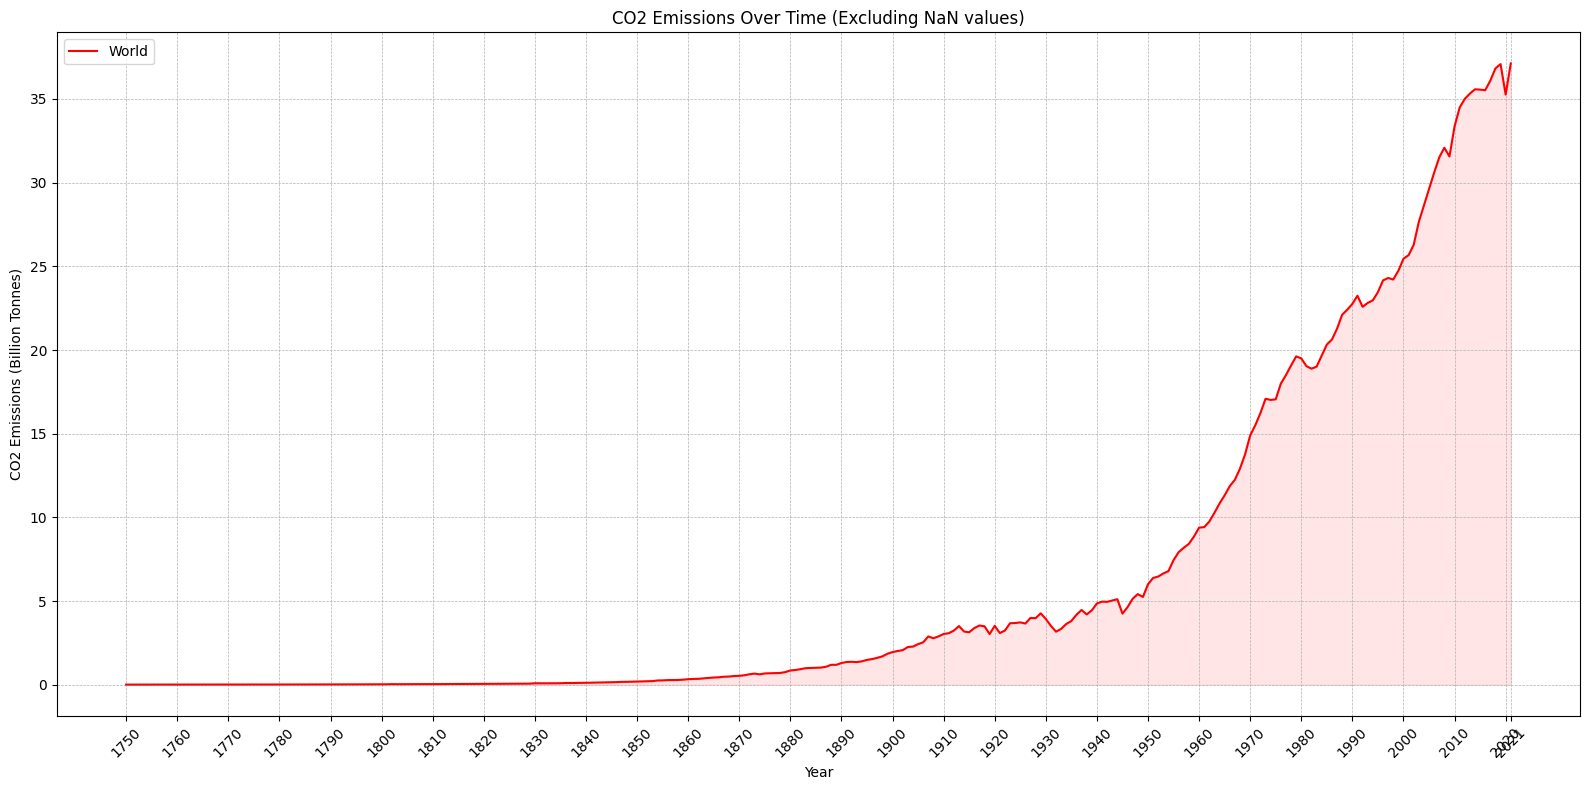

In [ ]:
country_color_dict = {
    "World": "red"
}

pollution_region_df_clean = pollution_region_df.dropna(subset=list(country_color_dict.keys()), how='all')

all_years = pollution_region_df_clean.index.year.unique()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]
tick_dates_clean = pollution_region_df_clean[pollution_region_df_clean.index.year.isin(ticks_years)].index.unique()

plt.figure(figsize=(16, 8))

for country, color in country_color_dict.items():
    data_values = pollution_region_df_clean[country] / 1e9
    sns.lineplot(data=pollution_region_df_clean, x=pollution_region_df_clean.index, y=data_values, label=country, color=color)
    plt.fill_between(pollution_region_df_clean.index, data_values, color=color, alpha=0.1)

plt.title("CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Billion Tonnes)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.xticks(tick_dates_clean, labels=[date.year for date in tick_dates_clean], rotation=45)

plt.tight_layout()
plt.show()

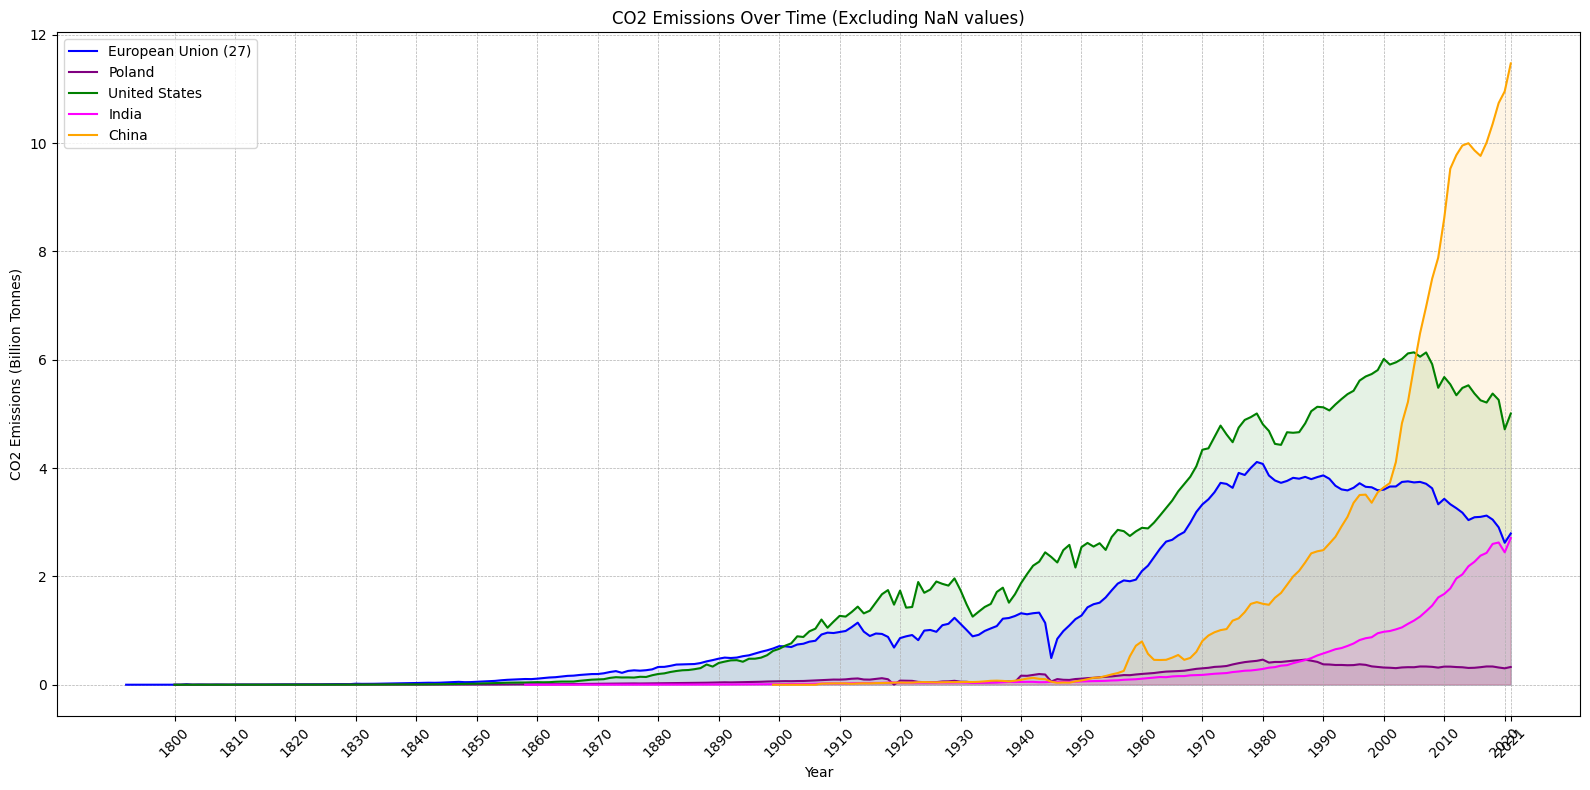

In [ ]:
country_color_dict = {
    "European Union (27)": "blue",
    "Poland": "purple",
    "United States": "green",
    "India": "magenta",
    "China": "orange"
}

pollution_region_df_clean = pollution_region_df.dropna(subset=list(country_color_dict.keys()), how='all')

all_years = pollution_region_df_clean.index.year.unique()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]
tick_dates_clean = pollution_region_df_clean[pollution_region_df_clean.index.year.isin(ticks_years)].index.unique()

plt.figure(figsize=(16, 8))

for country, color in country_color_dict.items():
    data_values = pollution_region_df_clean[country] / 1e9
    sns.lineplot(data=pollution_region_df_clean, x=pollution_region_df_clean.index, y=data_values, label=country, color=color)
    plt.fill_between(pollution_region_df_clean.index, data_values, color=color, alpha=0.1)

plt.title("CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Billion Tonnes)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.xticks(tick_dates_clean, labels=[date.year for date in tick_dates_clean], rotation=45)

plt.tight_layout()
plt.show()


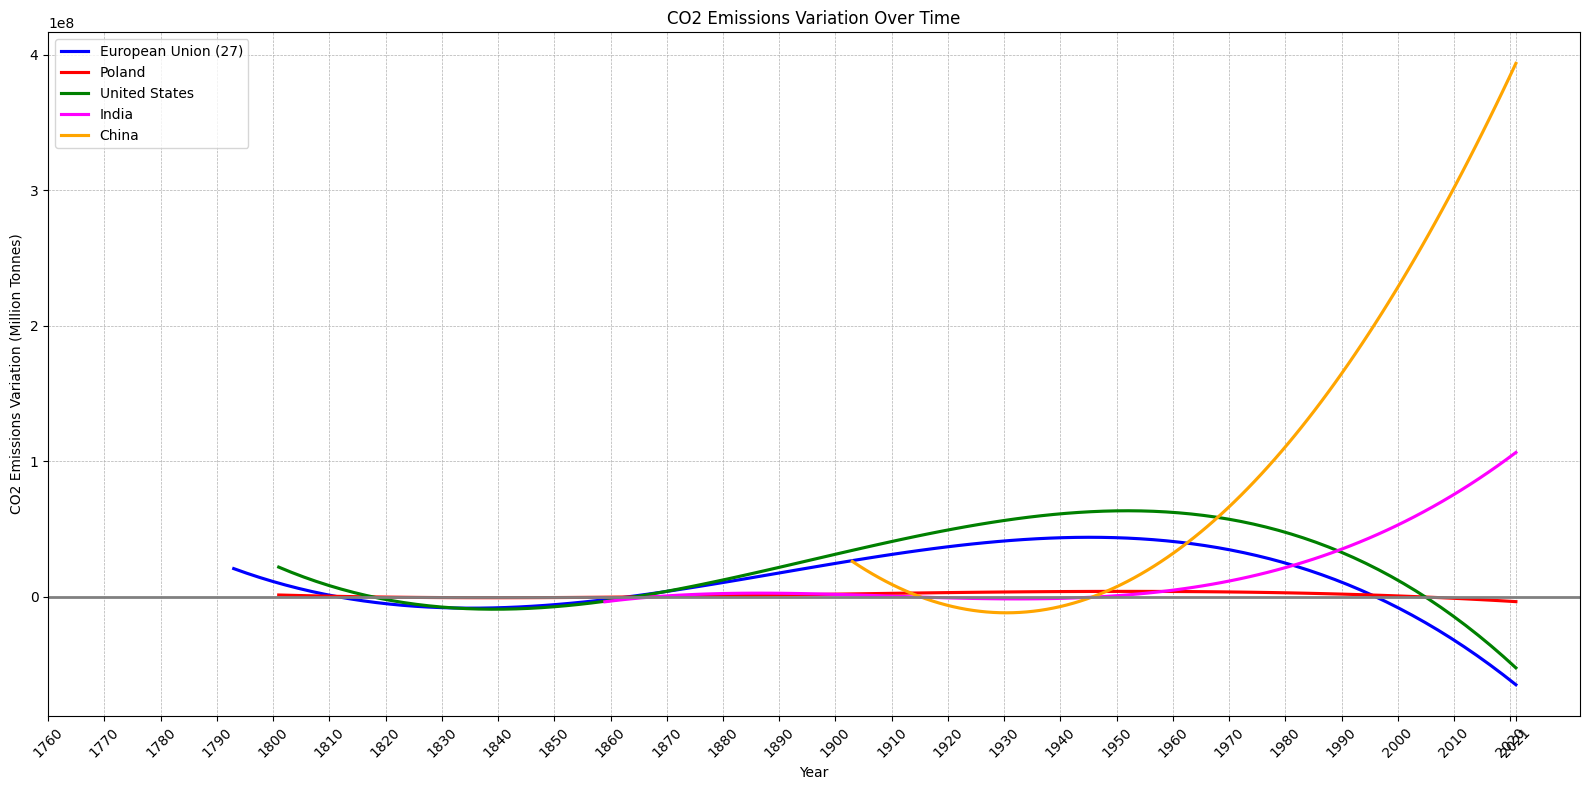

In [ ]:
country_color_dict = {
    "European Union (27)": "blue",
    "Poland": "red",
    "United States": "green",
    "India": "magenta",
    "China": "orange"
}

all_years = pollution_variation_df.index.year.unique()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]

plt.figure(figsize=(16, 8))

for country, color in country_color_dict.items():
    x_values = pollution_variation_df.index.year
    y_values = pollution_variation_df[country]

    sns.regplot(x=x_values, y=y_values,
                label=country, color=color, scatter=False, ci=None, order=3)

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.title("CO2 Emissions Variation Over Time")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions Variation (Million Tonnes)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ticks_years, rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-74-e34eae719b82>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_temp_filtered['Year'] = global_temp_filtered.index.year


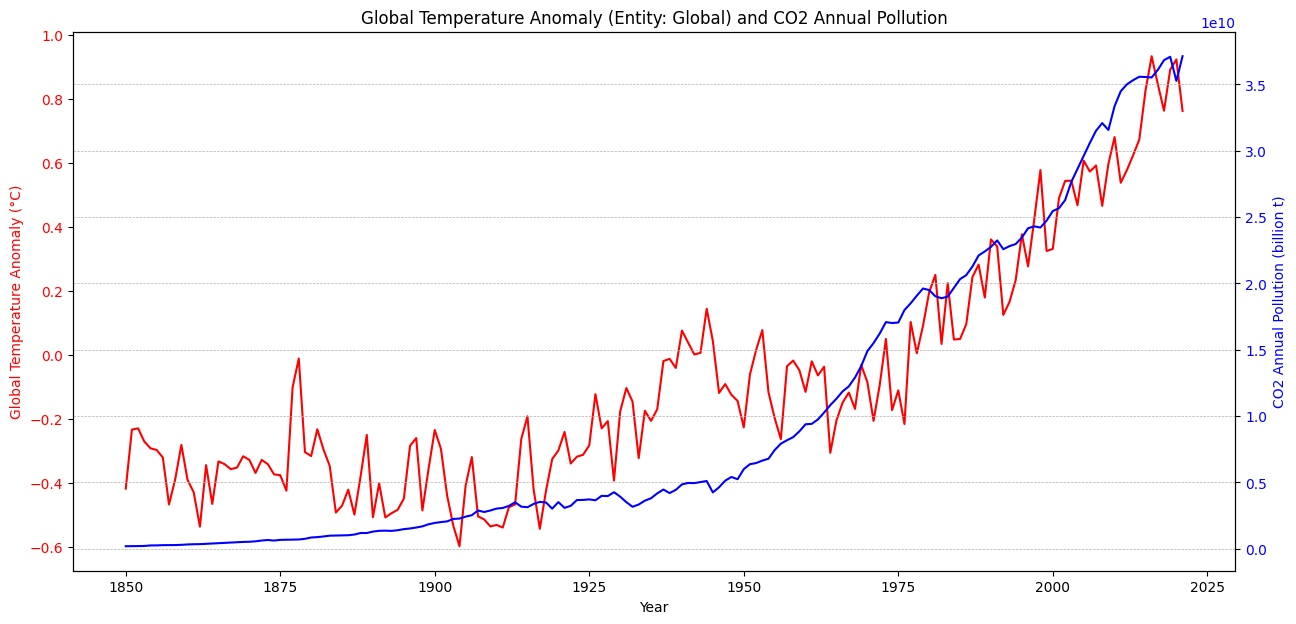

In [ ]:
global_temp_filtered = global_temp_anomaly_df[global_temp_anomaly_df['Entity'] == 'Global']
global_temp_filtered['Year'] = global_temp_filtered.index.year
pollution_region_df['Year'] = pollution_region_df.index.year
pollution_region_df_corr = pollution_region_df[['Year', 'World']]

merged_df_updated = pd.merge(global_temp_filtered, pollution_region_df_corr, on='Year', how='inner')

fig, ax1 = plt.subplots(figsize=(15, 7))

ax1.set_xlabel('Year')
ax1.set_ylabel('Global Temperature Anomaly (°C)', color='red')
ax1.plot(merged_df_updated['Year'], merged_df_updated['Global average temperature anomaly relative to 1961-1990'], color='red', label='Temperature Anomaly')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('CO2 Annual Pollution (billion t)', color='blue')
ax2.plot(merged_df_updated['Year'], merged_df_updated['World'], color='blue', label='CO2 Annual Pollution (billion t)')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Global Temperature Anomaly (Entity: Global) and CO2 Annual Pollution')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


<Figure size 1200x800 with 0 Axes>

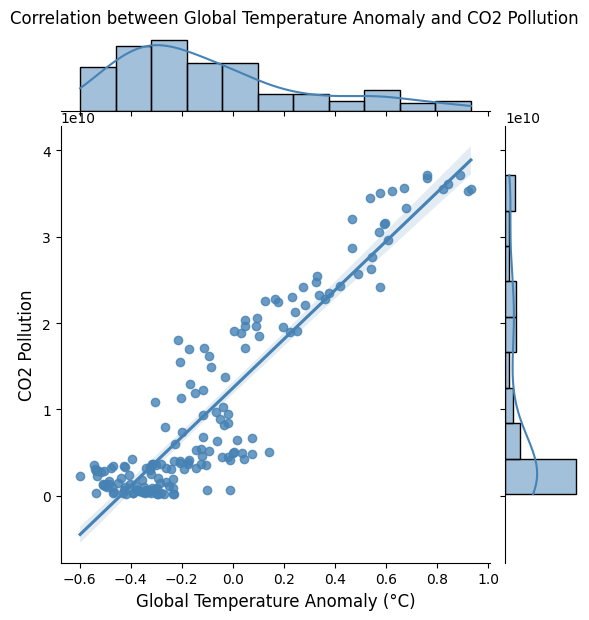

0.9221707125570543

In [ ]:
plt.figure(figsize=(12, 8))
sns_plot = sns.jointplot(data=merged_df_updated,
                         x='Global average temperature anomaly relative to 1961-1990',
                         y='World',
                         kind='reg',
                         color='steelblue')
sns_plot.set_axis_labels('Global Temperature Anomaly (°C)', 'CO2 Pollution', fontsize=12)
plt.suptitle('Correlation between Global Temperature Anomaly and CO2 Pollution', y=1.02)
plt.show()
merged_df_updated[['Global average temperature anomaly relative to 1961-1990', 'World']].corr().iloc[0, 1]

# Global and Krakow temperatures

<ipython-input-64-a8e2b2e560f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_only_df["year"] = global_only_df.index.year


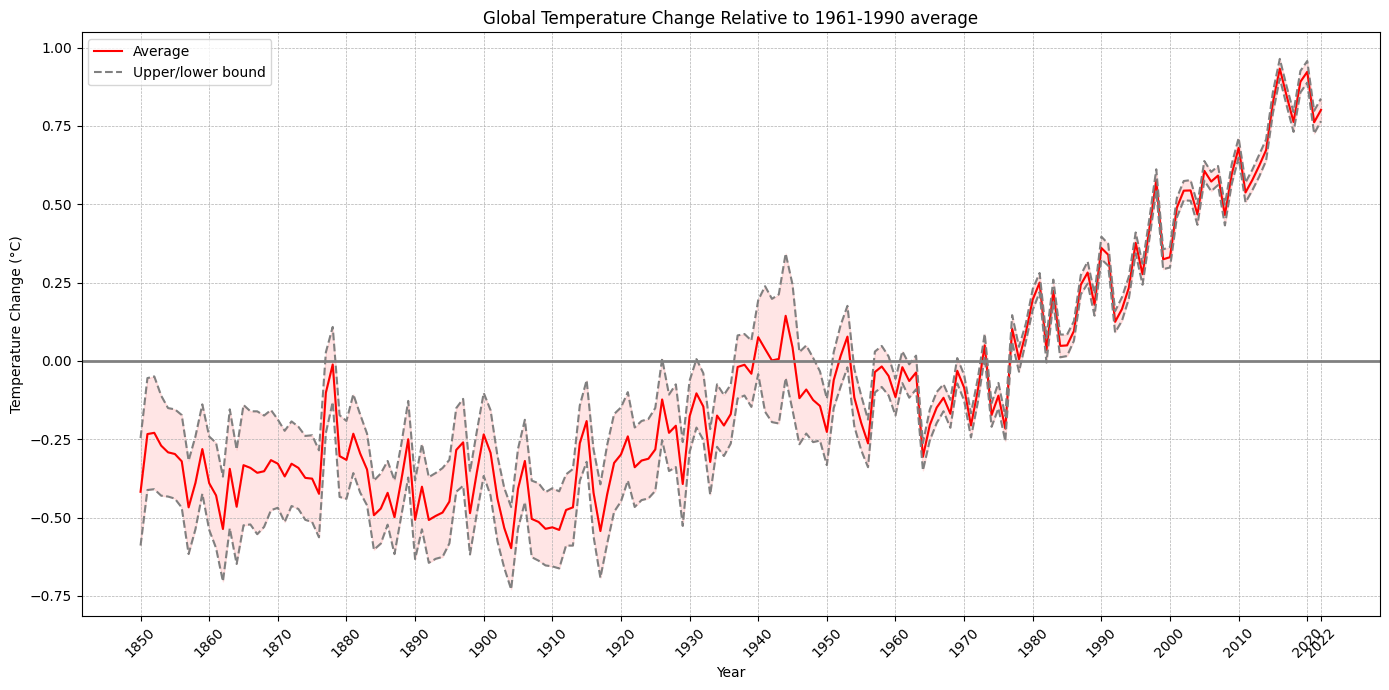

In [ ]:
global_only_df = global_temp_anomaly_df[global_temp_anomaly_df["Entity"] == "Global"]
global_only_df["year"] = global_only_df.index.year

plt.figure(figsize=(14, 7))

mean_col = "Global average temperature anomaly relative to 1961-1990"
upper_col = "Upper bound (95% confidence interval) of the annual temperature anomaly"
lower_col = "Lower bound (95% confidence interval) of the annual temperature anomaly"

plt.fill_between(global_only_df.index,
                 global_only_df[mean_col],
                 global_only_df[upper_col],
                 color="red", alpha=0.1)

plt.fill_between(global_only_df.index,
                 global_only_df[mean_col],
                 global_only_df[lower_col],
                 color="red", alpha=0.1)

sns.lineplot(data=global_only_df, x="dt", y=mean_col, label="Average", color="red")
sns.lineplot(data=global_only_df, x="dt", y=upper_col, label="Upper/lower bound", color="grey", linestyle='--')
sns.lineplot(data=global_only_df, x="dt", y=lower_col, color="grey", linestyle='--')

ticks_df = global_only_df[(global_only_df['year'] % 10 == 0) | (global_only_df['year'] == global_only_df['year'].max())]

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.title("Global Temperature Change Relative to 1961-1990 average")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ticks_df.index, ticks_df['year'],rotation=45)
plt.tight_layout()
plt.show()

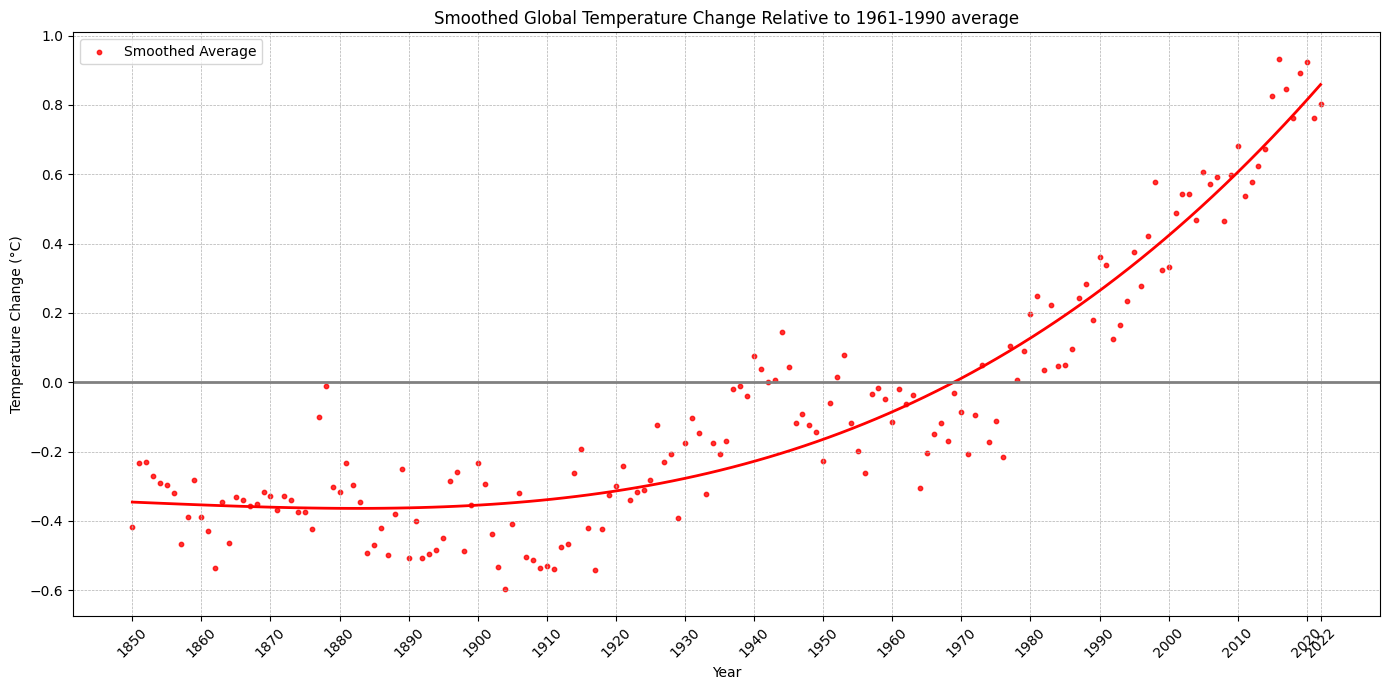

In [ ]:
plt.figure(figsize=(14, 7))

sns.regplot(data=global_only_df, x="year", y="Global average temperature anomaly relative to 1961-1990", label="Smoothed Average", color="red", scatter=True, scatter_kws={"s": 10}, order=3, ci=None, line_kws={'lw': 2})

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.title("Smoothed Global Temperature Change Relative to 1961-1990 average")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ticks_df["year"], rotation=45)
plt.tight_layout()
plt.show()

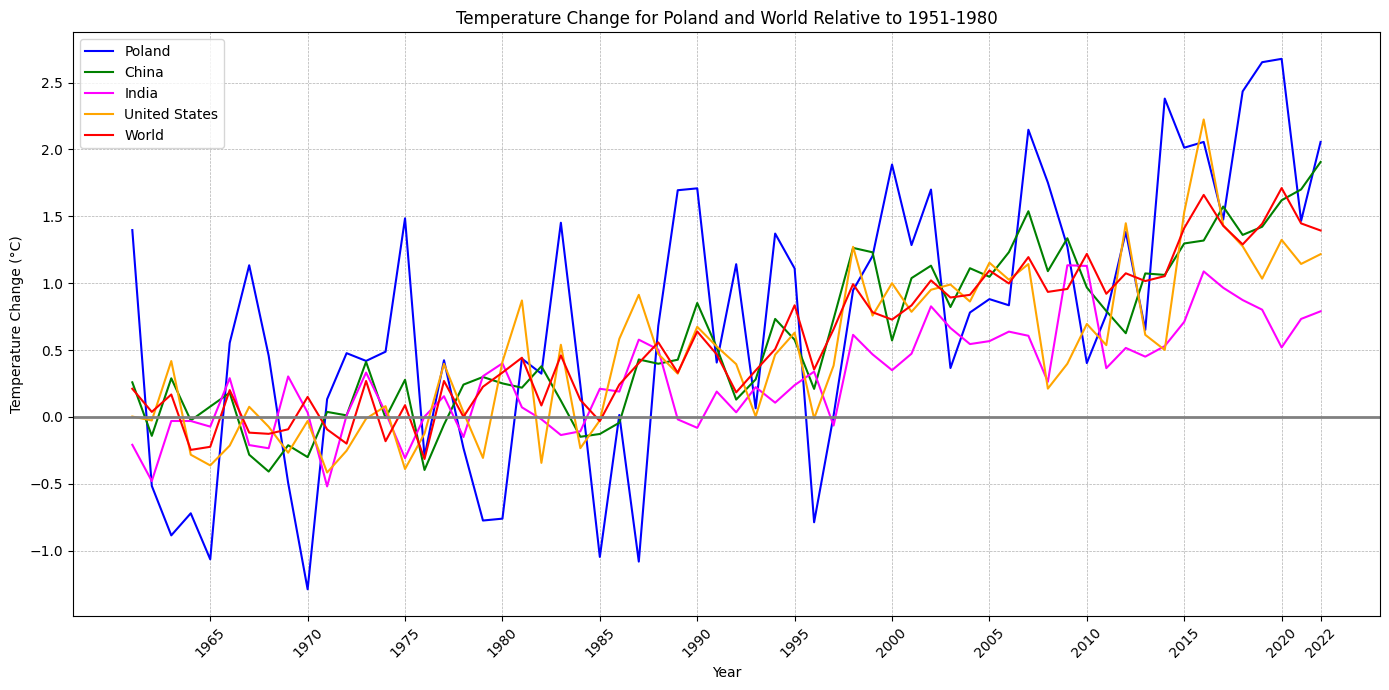

In [ ]:
palette = {
    'Poland': 'blue',
    'China': 'green',
    'India': 'magenta',
    'United States': 'orange',
    'World': 'red'
}

ticks_df_country = country_temp_df[(country_temp_df["Year"] % 5 == 0) | (country_temp_df["Year"] == country_temp_df["Year"].max())]

plt.figure(figsize=(14, 7))

for country, color in palette.items():
    sns.lineplot(data=country_temp_df, x="Year", y=country, label=country, color=color)

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.xticks(ticks_df_country["Year"].unique(), rotation=45)
plt.title("Temperature Change for Poland and World Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


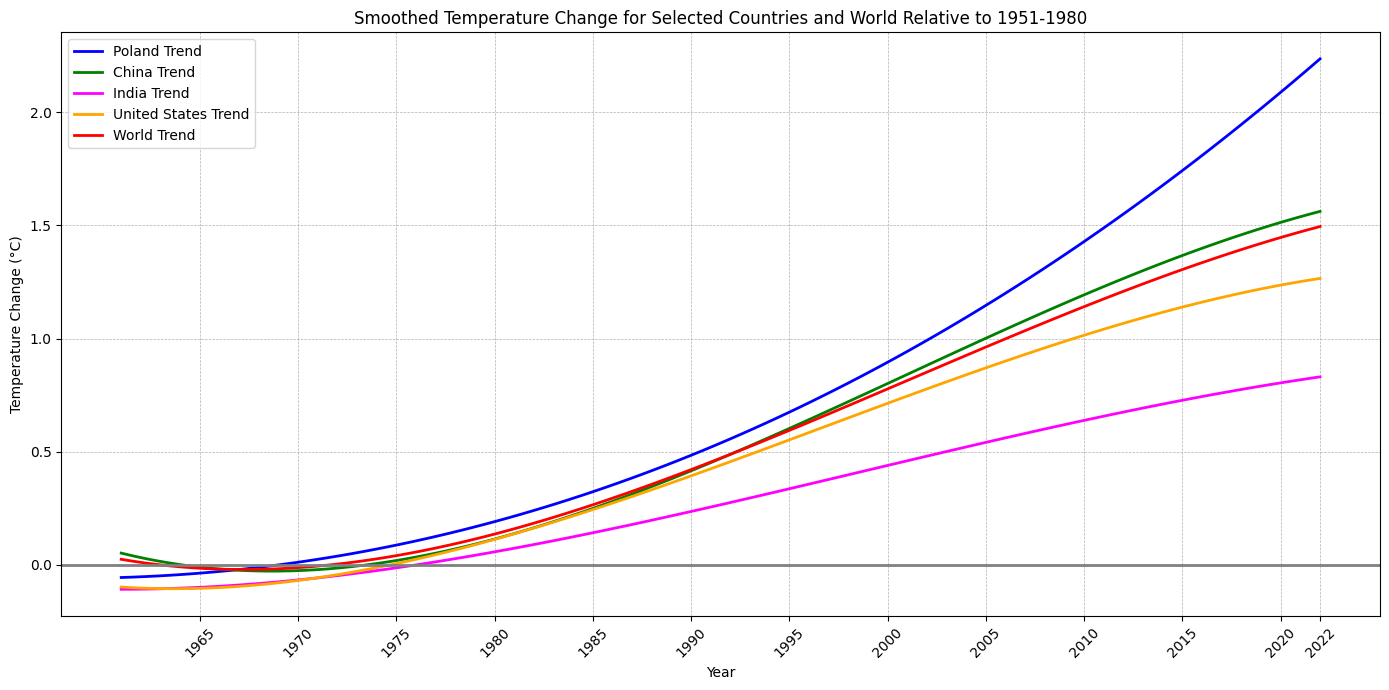

In [ ]:
plt.figure(figsize=(14, 7))

for country, color in palette.items():
    sns.regplot(data=country_temp_df, x="Year", y=country, label=f"{country} Trend", color=color, scatter=False, order=3, ci=None, line_kws={'lw': 2})

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.xticks(ticks_df_country["Year"].unique(), rotation=45)
plt.title("Smoothed Temperature Change for Selected Countries and World Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

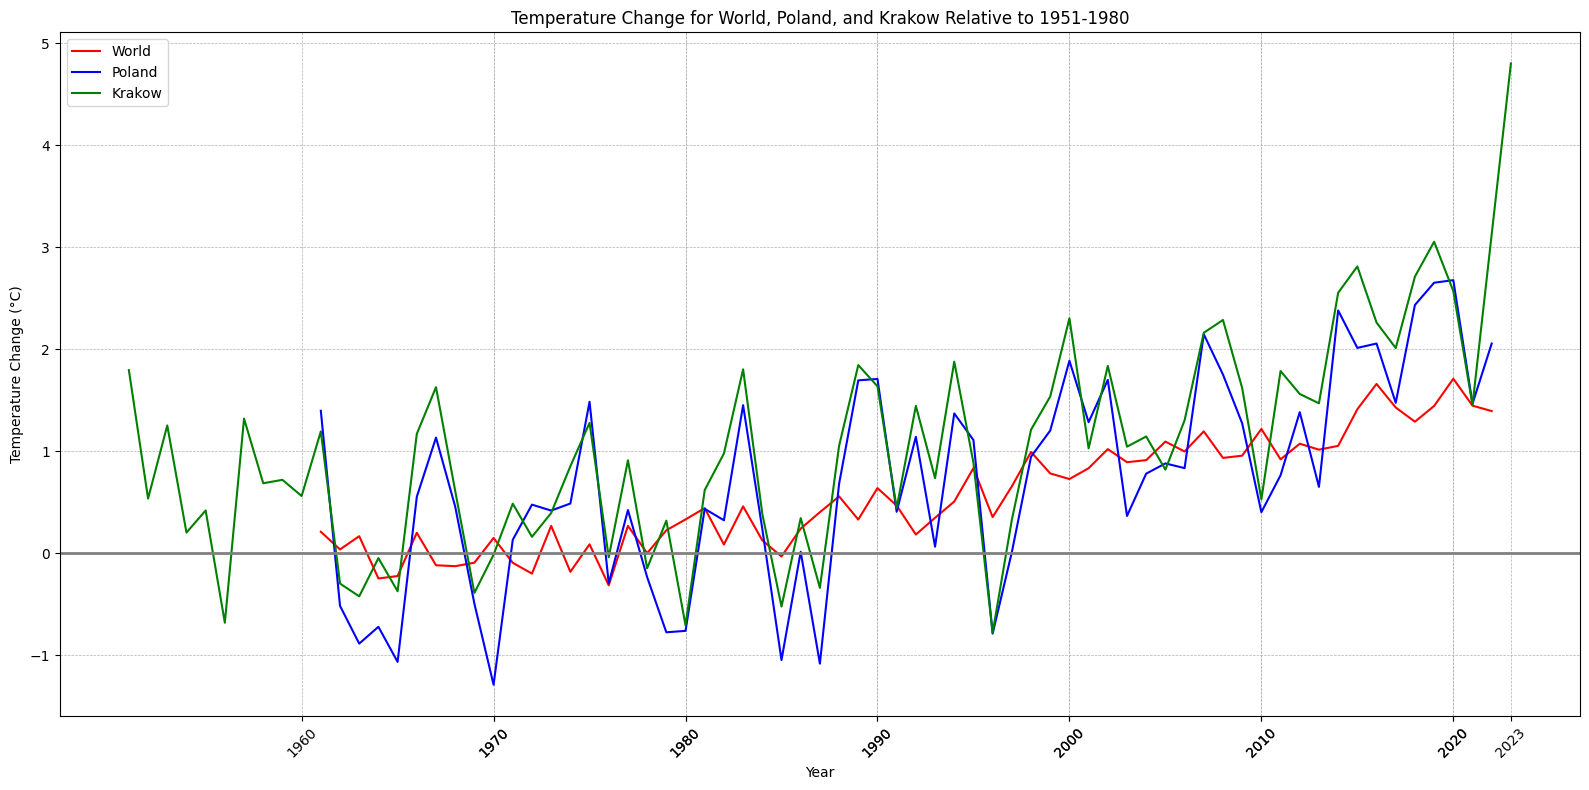

In [ ]:
krakow_yearly_relative_temp_df["year"] = krakow_yearly_relative_temp_df.index.year

plt.figure(figsize=(16, 8))

palette_extended = {
    'World': 'red',
    'Poland': 'blue',
    'Krakow': 'green'
}

for country, color in palette_extended.items():
    if country in ['World', 'Poland']:
        sns.lineplot(data=country_temp_df, x="Year", y=country, label=country, color=color)

sns.lineplot(data=krakow_yearly_relative_temp_df, x="year", y="Average monthly temperature [°C]", label="Krakow", color=palette_extended["Krakow"])

all_years = country_temp_df["Year"].unique().tolist() + krakow_yearly_relative_temp_df["year"].unique().tolist()
ticks_years = [year for year in all_years if year % 10 == 0] + [max(all_years)]

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.xticks(ticks_years, rotation=45)
plt.title("Temperature Change for World, Poland, and Krakow Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


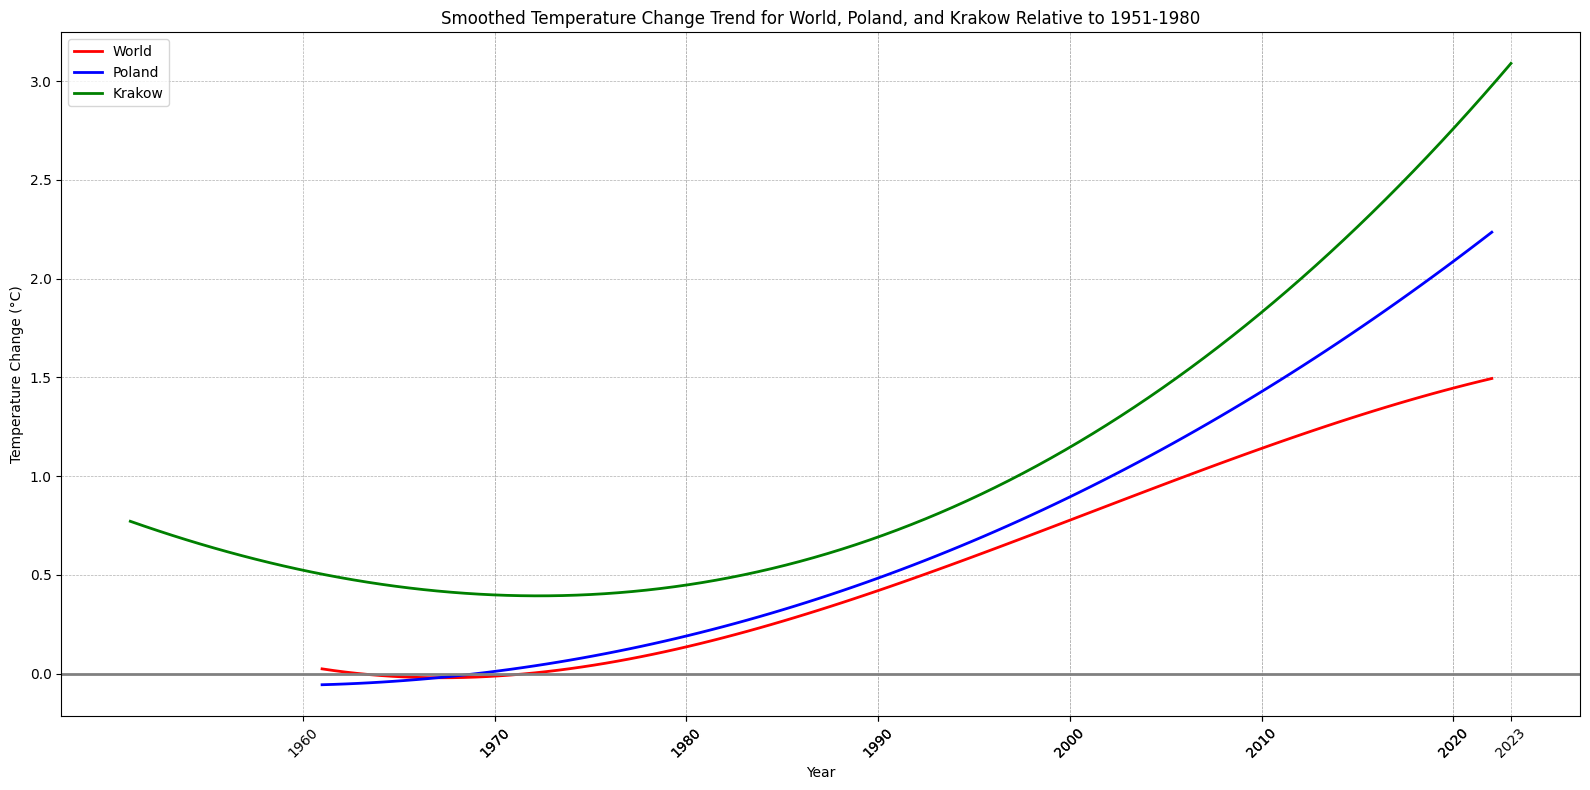

In [ ]:
plt.figure(figsize=(16, 8))

for country, color in palette_extended.items():
    if country in ['World', 'Poland']:
        sns.regplot(data=country_temp_df, x="Year", y=country, label=country, color=color, scatter=False, order=3, ci=None, line_kws={'lw': 2})
    else:
        sns.regplot(data=krakow_yearly_relative_temp_df, x="year", y="Average monthly temperature [°C]", label="Krakow", color=color, scatter=False, order=3, ci=None, line_kws={'lw': 2})

plt.axhline(0, color='grey', linestyle='-', linewidth=2)
plt.xticks(ticks_years, rotation=45)
plt.title("Smoothed Temperature Change Trend for World, Poland, and Krakow Relative to 1951-1980")
plt.xlabel("Year")
plt.ylabel("Temperature Change (°C)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


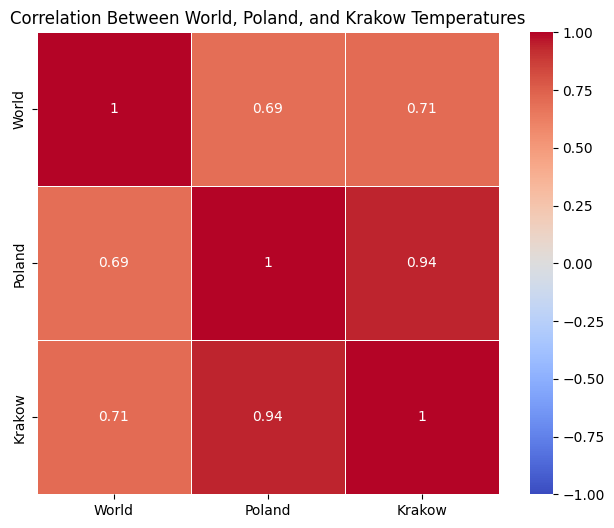

In [ ]:
merged_df = pd.merge(country_temp_df[['Year', 'World', 'Poland']], krakow_yearly_relative_temp_df[['year', 'Average monthly temperature [°C]']], left_on="Year", right_on="year", how="inner")

merged_df.drop(columns=['year'], inplace=True)
merged_df.rename(columns={'Average monthly temperature [°C]': 'Krakow'}, inplace=True)

correlation_matrix = merged_df[['World', 'Poland', 'Krakow']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Correlation Between World, Poland, and Krakow Temperatures")
plt.show()

# Krakow NO2 and CO pollution concentration and heat inversion effect.

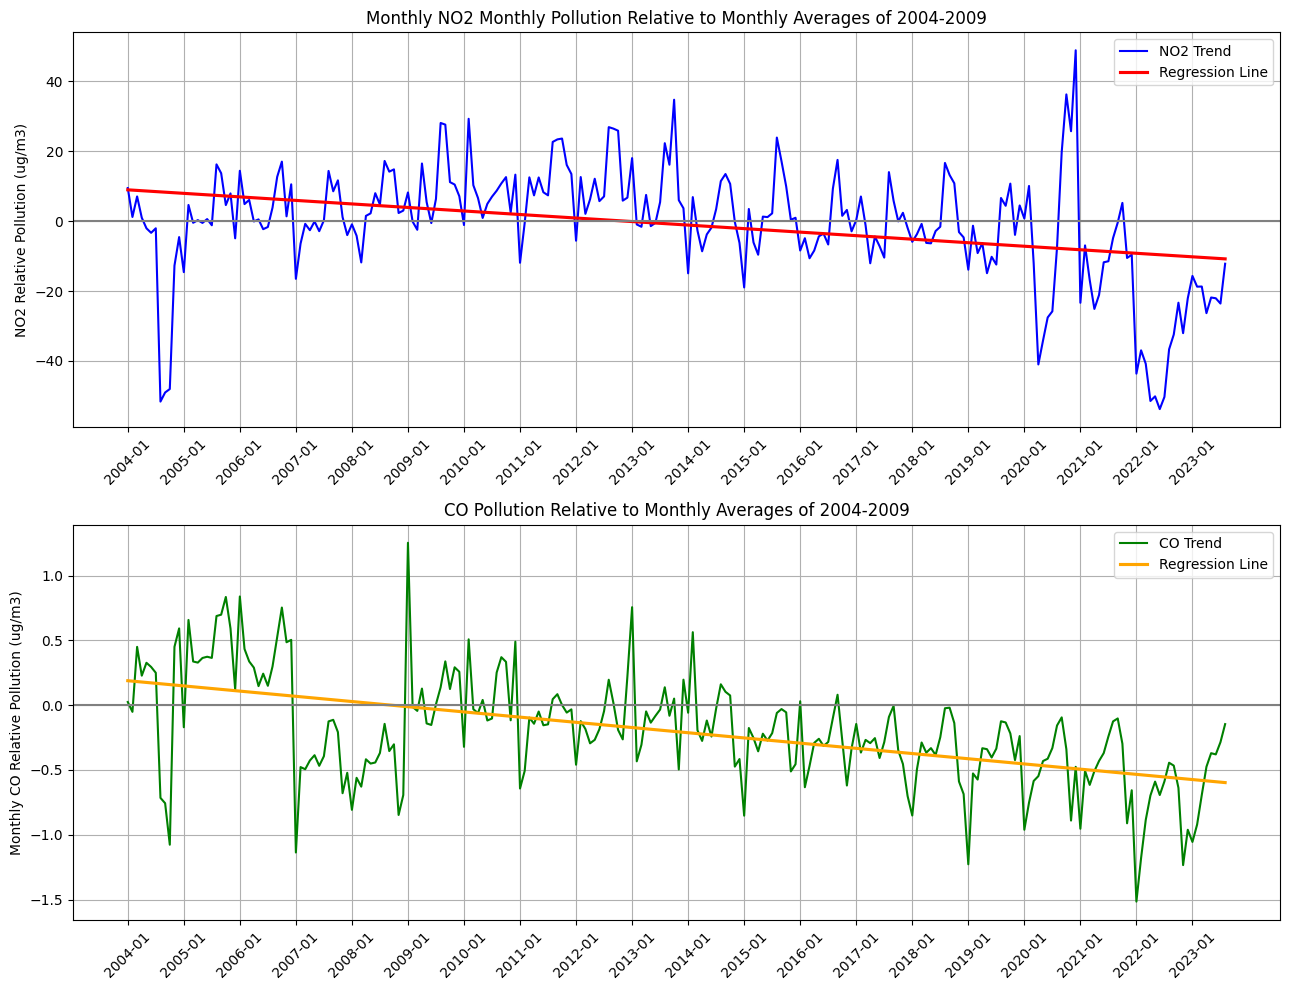

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10))

sns.lineplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='NO2', data=krakow_monthly_relative_pollution_df, ax=ax1, label='NO2 Trend', color='blue')
sns.regplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='NO2', data=krakow_monthly_relative_pollution_df, ax=ax1, scatter=False, ci=False, color='red', label='Regression Line')
ax1.axhline(0, color='grey', linestyle='-')
ax1.set_title('Monthly NO2 Pollution Relative to Monthly Averages of 2004-2009')
ax1.set_ylabel('NO2 Relative Pollution (ug/m3)')
ax1.set_xticks(np.arange(0, len(krakow_monthly_relative_pollution_df), 12))
ax1.set_xticklabels(krakow_monthly_relative_pollution_df.index.strftime('%Y-%m').tolist()[::12], rotation=45)
ax1.grid(True)
ax1.legend()

sns.lineplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='CO', data=krakow_monthly_relative_pollution_df, ax=ax2, label='CO Trend', color='green')
sns.regplot(x=np.arange(len(krakow_monthly_relative_pollution_df)), y='CO', data=krakow_monthly_relative_pollution_df, ax=ax2, scatter=False, ci=False, color='orange', label='Regression Line')
ax2.axhline(0, color='grey', linestyle='-')
ax2.set_title('CO Pollution Relative to Monthly Averages of 2004-2009')
ax2.set_ylabel('Monthly CO Relative Pollution (ug/m3)')
ax2.set_xticks(np.arange(0, len(krakow_monthly_relative_pollution_df), 12))
ax2.set_xticklabels(krakow_monthly_relative_pollution_df.index.strftime('%Y-%m').tolist()[::12], rotation=45)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


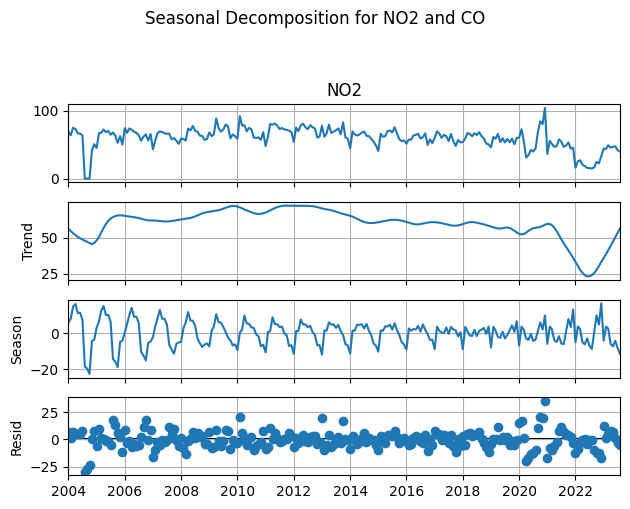

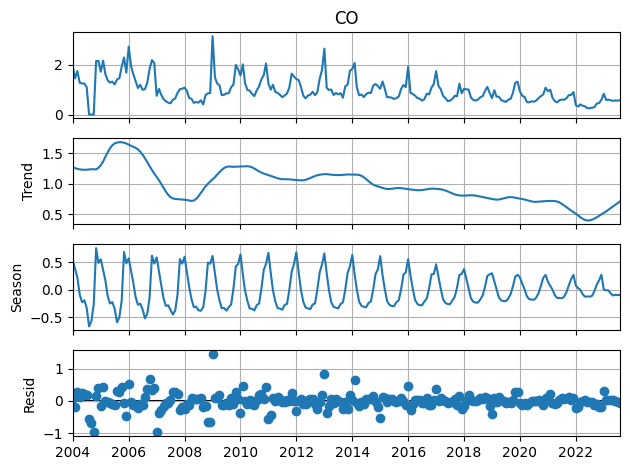

In [ ]:
stl_NO2 = STL(pollution_krakow_df['NO2'], seasonal=13).fit()
fig_NO2 = stl_NO2.plot()
for ax in fig_NO2.get_axes():
    ax.grid(True)
fig_NO2.suptitle('Seasonal Decomposition for NO2 and CO', y=1.05)
plt.tight_layout()
plt.show()

stl_CO = STL(pollution_krakow_df['CO'], seasonal=13).fit()
fig_CO = stl_CO.plot()
for ax in fig_CO.get_axes():
    ax.grid(True)
plt.tight_layout()
plt.show()

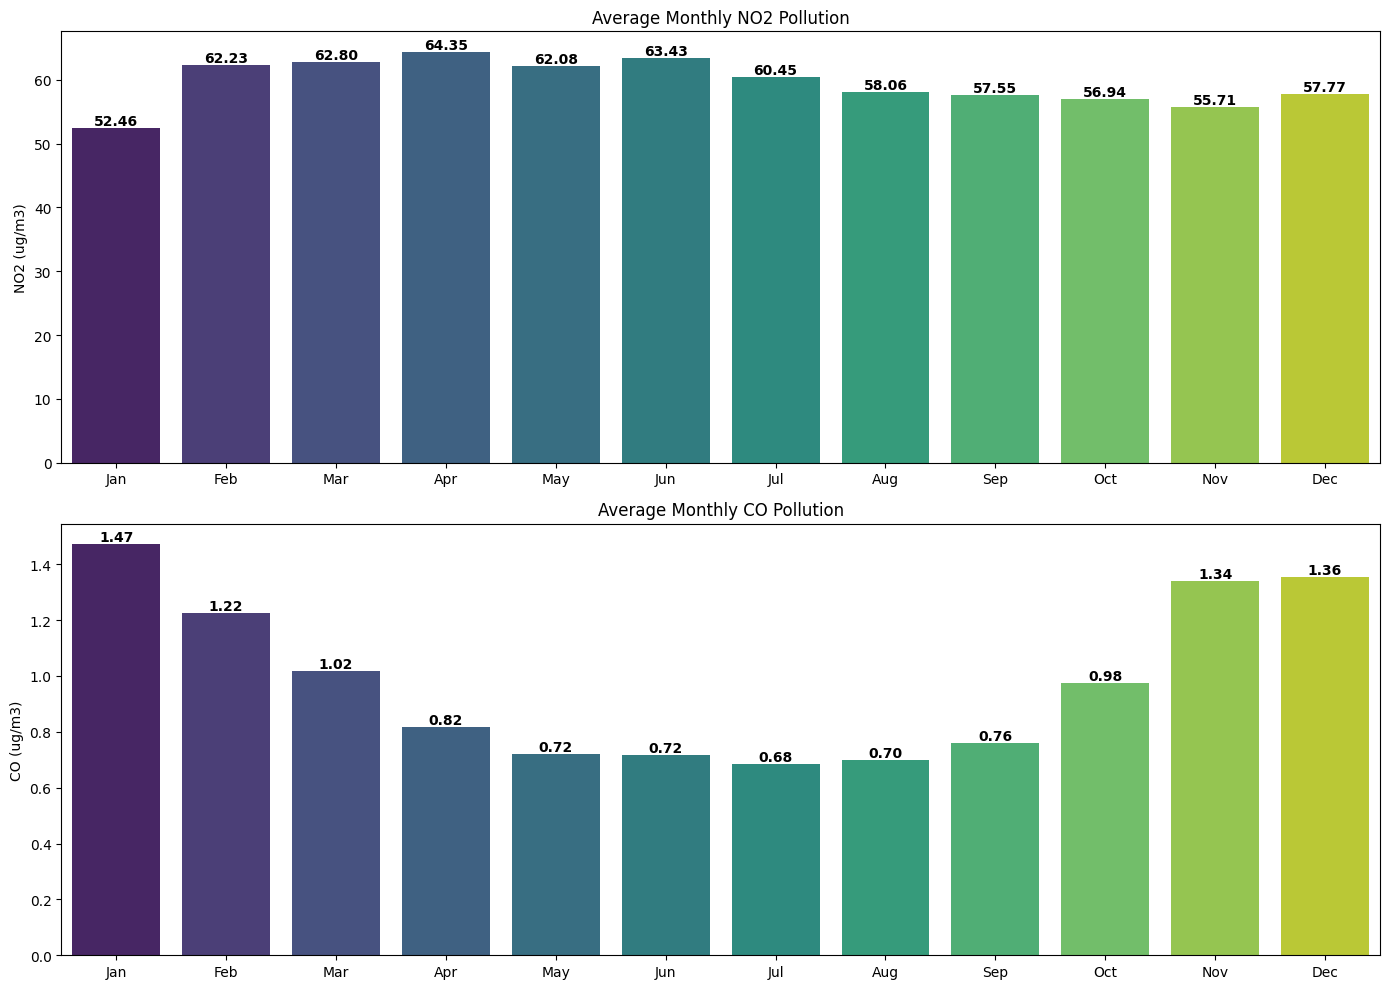

In [ ]:
pollution_krakow_df['month'] = pollution_krakow_df.index.month

monthly_avg_NO2 = pollution_krakow_df.groupby('month')['NO2'].mean()
monthly_avg_CO = pollution_krakow_df.groupby('month')['CO'].mean()

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))


sns.barplot(x=months, y=monthly_avg_NO2, ax=ax1, palette="viridis")
ax1.set_title('Average Monthly NO2 Pollution')
ax1.set_ylabel('NO2 (ug/m3)')
for idx, value in enumerate(monthly_avg_NO2):
    ax1.text(idx, value, f"{value:.2f}", ha="center", va="bottom", fontweight='bold')


sns.barplot(x=months, y=monthly_avg_CO, ax=ax2, palette="viridis")
ax2.set_title('Average Monthly CO Pollution')
ax2.set_ylabel('CO (ug/m3)')
for idx, value in enumerate(monthly_avg_CO):
    ax2.text(idx, value, f"{value:.2f}", ha="center", va="bottom", fontweight='bold')

plt.tight_layout()
plt.show()


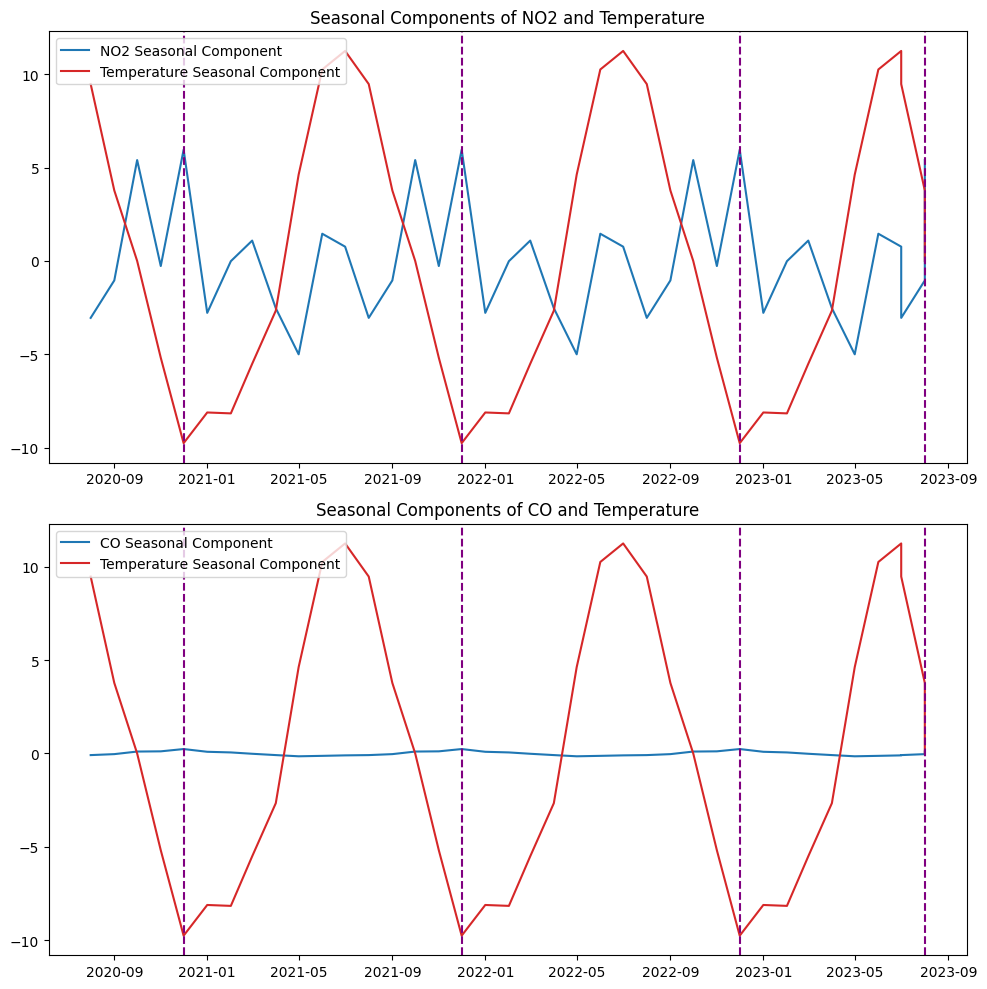

In [ ]:
end_date = krakow_temp_df.index.max()
start_date = end_date - pd.DateOffset(years=3)

filtered_temp_df = krakow_temp_df[(krakow_temp_df.index >= start_date) & (krakow_temp_df.index <= end_date)]
filtered_pollution_df = pollution_krakow_df[(pollution_krakow_df.index >= start_date) & (pollution_krakow_df.index <= end_date)]

merged_df = pd.merge(filtered_temp_df, filtered_pollution_df, left_index=True, right_index=True)

no2_seasonal = seasonal_decompose(merged_df['NO2'], model='additive', period=12).seasonal
temp_seasonal = seasonal_decompose(merged_df['Average monthly temperature [°C]'], model='additive', period=12).seasonal
co_seasonal = seasonal_decompose(merged_df['CO'], model='additive', period=12).seasonal

fig, axes = plt.subplots(2, 1, figsize=(10, 10))


axes[0].plot(no2_seasonal, label='NO2 Seasonal Component', color='tab:blue')
axes[0].plot(temp_seasonal, label='Temperature Seasonal Component', color='tab:red')
for year in range(start_date.year, end_date.year + 1):
    max_no2_for_year = no2_seasonal[str(year)].idxmax()
    axes[0].axvline(x=max_no2_for_year, color='purple', linestyle='--')
axes[0].set_title('Seasonal Components of NO2 and Temperature')
axes[0].legend()


axes[1].plot(co_seasonal, label='CO Seasonal Component', color='tab:blue')
axes[1].plot(temp_seasonal, label='Temperature Seasonal Component', color='tab:red')
for year in range(start_date.year, end_date.year + 1):
    max_co_for_year = co_seasonal[str(year)].idxmax()
    axes[1].axvline(x=max_co_for_year, color='purple', linestyle='--')
axes[1].set_title('Seasonal Components of CO and Temperature')
axes[1].legend()

plt.tight_layout()
plt.show()


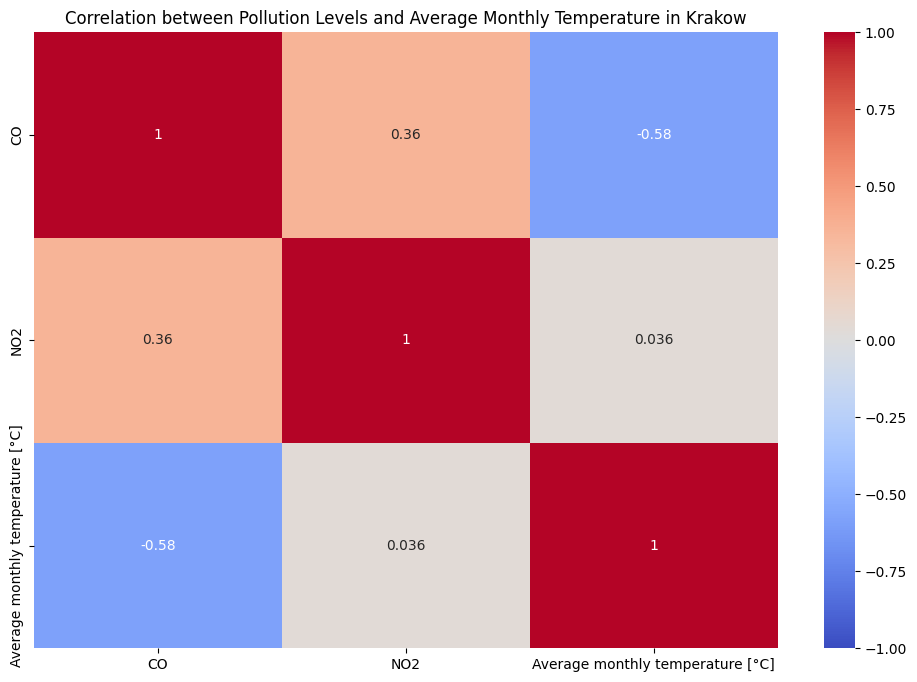

In [ ]:
merged_df = pd.merge(pollution_krakow_df[['CO','NO2']], krakow_temp_df[['Average monthly temperature [°C]']], left_index=True, right_index=True)

correlation_matrix = merged_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Pollution Levels and Average Monthly Temperature in Krakow')
plt.show()
